In [ ]:
!pip uninstall -y qiskit qiskit-aer qiskit-terra

In [ ]:
!pip install --force-reinstall "qiskit==0.43.1" "qiskit-aer==0.12.0" "qiskit-terra==0.24.1"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 571.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 17.0 MB/s eta 0:00:00


In [ ]:
pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136897 sha256=0af8431c03d339abc973f9d0a57d29478b171d8d6fce897148c8576e85fd36ca
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [ ]:
!pip install qiskit qiskit-aer matplotlib networkx

In [ ]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [ ]:
# Define a simple graph
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
n = len(G.nodes)

In [ ]:
# Define beta and gamma
beta = Parameter('β')
gamma = Parameter('γ')

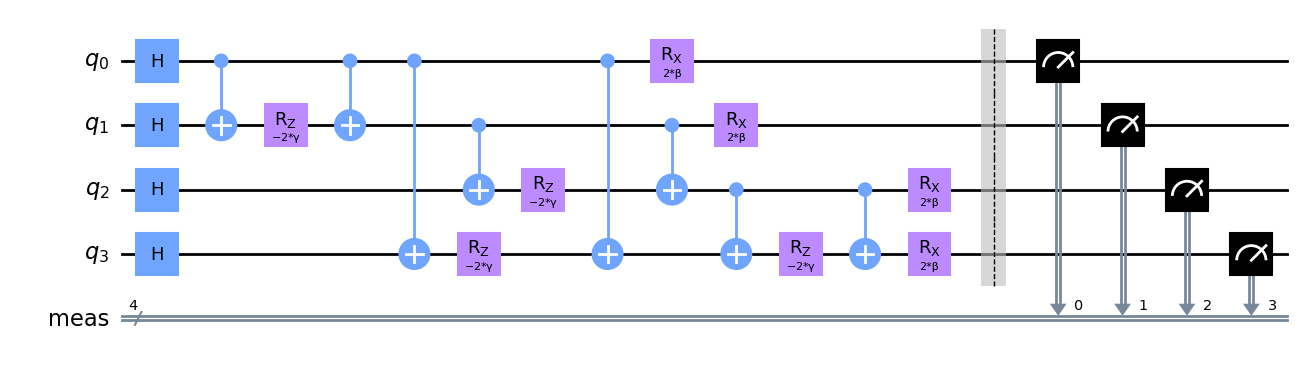

In [ ]:
# Define QAOA circuit for MaxCut
qc = QuantumCircuit(n)
qc.h(range(n))
for i, j in G.edges:
    qc.cx(i, j)
    qc.rz(-2 * gamma, j)
    qc.cx(i, j)
qc.rx(2 * beta, range(n))
qc.measure_all()
qc.draw('mpl')

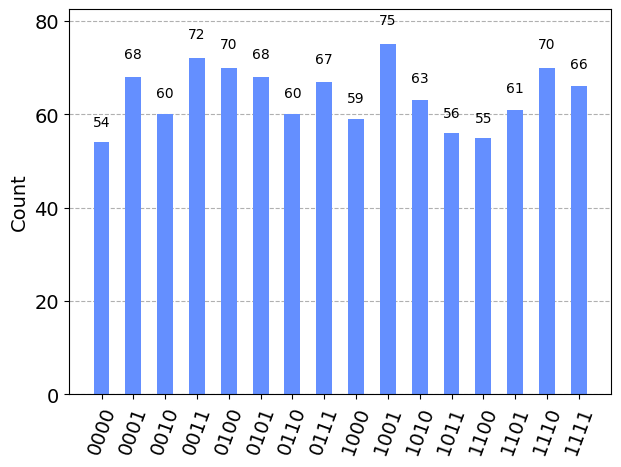

In [ ]:
# Bind values and simulate
bound_qc = qc.bind_parameters({beta: np.pi/4, gamma: np.pi/2})
sim = Aer.get_backend('aer_simulator')
result = sim.run(bound_qc, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

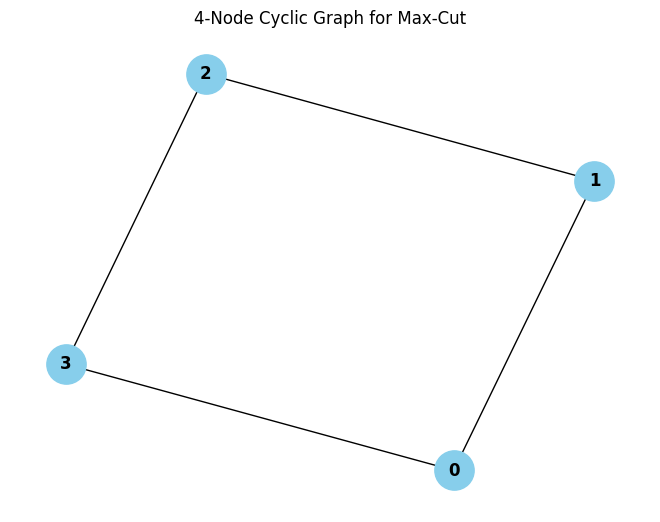

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()
graph.add_edges_from([(0,1),(1,2),(2,3),(3,0)])

nx.draw(graph, with_labels=True, node_color='skyblue', node_size=800, font_weight='bold' )
plt.title("4-Node Cyclic Graph for Max-Cut")
plt.show()

Optimized β: 0.7853817741076154
Optimized γ: 1.5708949746087537
Max-Cut Expectation Value: 1.978515625


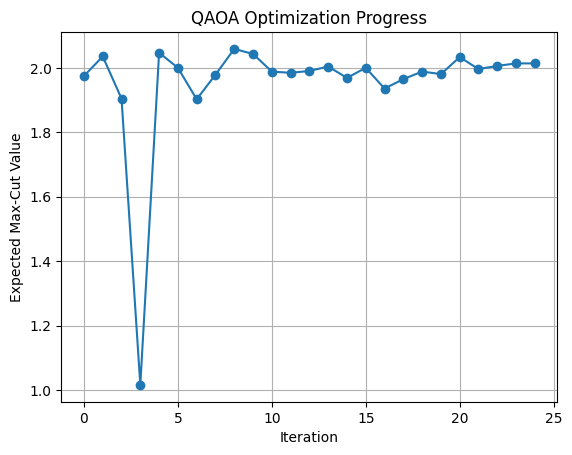

In [ ]:
from scipy.optimize import minimize

# --- Define expectation value for Max-Cut ---
def maxcut_cost(bitstring, graph):
    cost = 0
    for i, j in graph.edges():
        if bitstring[i] != bitstring[j]:
            cost += 1
    return cost

def expectation_value(params, qc_template, graph):
    beta, gamma = params
    bound_qc = qc_template.bind_parameters({beta_param: beta, gamma_param: gamma})
    sim = Aer.get_backend('aer_simulator')
    result = sim.run(bound_qc, shots=1024).result()
    counts = result.get_counts()

    exp_val = 0
    total = sum(counts.values())
    for bitstring, count in counts.items():
        bitstring = bitstring[::-1]  # reverse due to Qiskit ordering
        cost = maxcut_cost(bitstring, graph)
        exp_val += cost * count
    return -exp_val / total  # negative for minimization

# --- Set up parameterized circuit again ---
beta_param = Parameter('β')
gamma_param = Parameter('γ')

qc_template = QuantumCircuit(n)
qc_template.h(range(n))
for i, j in G.edges:
    qc_template.cx(i, j)
    qc_template.rz(-2 * gamma_param, j)
    qc_template.cx(i, j)
qc_template.rx(2 * beta_param, range(n))
qc_template.measure_all()

# --- Track optimization ---
cost_history = []

def callback_fn(x):
    cost = -expectation_value(x, qc_template, G)  # flip sign back
    cost_history.append(cost)

# --- Run optimizer ---
result = minimize(
    lambda params: expectation_value(params, qc_template, G),
    x0=[np.pi / 4, np.pi / 2],
    method='COBYLA',
    callback=callback_fn
)

# --- Print final result ---
print("Optimized β:", result.x[0])
print("Optimized γ:", result.x[1])
print("Max-Cut Expectation Value:", -result.fun)

# --- Plot optimization progress ---
plt.plot(cost_history, marker='o')
plt.title("QAOA Optimization Progress")
plt.xlabel("Iteration")
plt.ylabel("Expected Max-Cut Value")
plt.grid(True)
plt.show()
